## Test of the Graph Hierarchies

In [2]:
%matplotlib inline

import os.path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
from scipy.spatial.transform import Rotation

from pygsp import graphs, filters, plotting, reduction
from fgsp.graph.wavelet_evaluator import WaveletEvaluator
from fgsp.graph.global_graph import GlobalGraph
from fgsp.common.config import ClientConfig
from fgsp.controller.signal_handler import SignalHandler
from fgsp.classifier.top_classifier import TopClassifier

from fgsp.graph.hierarchical_graph import HierarchicalGraph
from fgsp.classifier.downstream_result import DownstreamResult

import seaborn as sns

%load_ext autoreload
%autoreload 2

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
def create_signal_from_traj(traj):
    traj_origin = traj[0,:]
    pos_signal = (traj - traj_origin).squeeze()
    x_pos = np.linalg.norm(pos_signal, ord=2, axis=1)
    return x_pos

## 1. Test of Simple Displacement

[1667893568853726.5] GlobalGraph: Initialized.
[1667893568997768.5] GlobalGraph: Initialized.


(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Graph(n_vertices=9, n_edges=25)'}>)

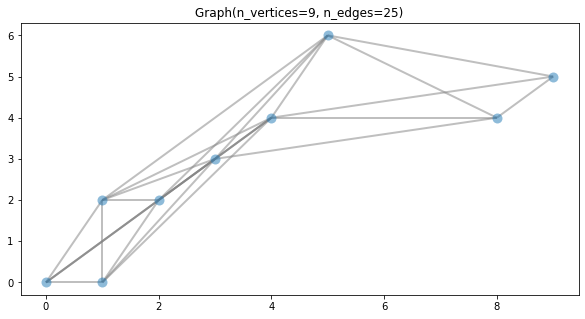

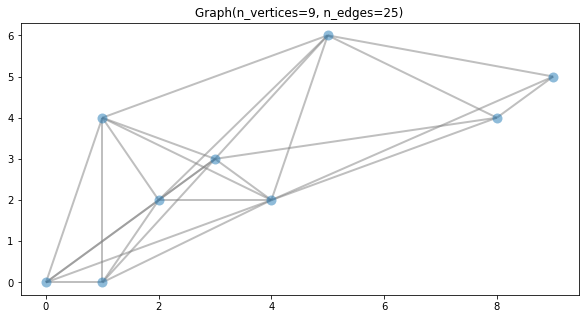

In [4]:
config = ClientConfig()
config.construction_method = 'r3'

opt_traj = np.array([[0,0,0,0,0],[0,1,1,0,1],[0,2,1,2,1],[1,3,2,2,1],[1,4,3,3,1],[1,5,4,4,1],[2,6,5,6,2], [2,7,8,4,2], [2,8,9,5,2]])
opt_graph = GlobalGraph(config)
opt_graph.build_from_poses(opt_traj[:,2:])
opt_graph.G.plot()

est_traj = np.copy(opt_traj)
# Initial test
# est_traj[2] += [0,0,3,0,0]
# est_traj[3] += [0,0,3,0,0]

# New test
est_traj[2] += [0,0,3,0,0]
est_traj[5] += [0,0,-3,0,0]


est_graph = GlobalGraph(config)
est_graph.build_from_poses(est_traj[:,2:])
est_graph.G.plot()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1667897041973627.8] WaveletEvaluator: Computing wavelets for 6 scales.


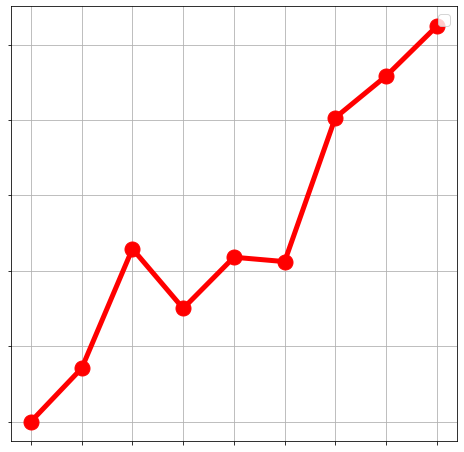

In [61]:
# Compute wavelets
n_scales = 6
opt_eval = WaveletEvaluator(n_scales)
opt_psi = opt_eval.compute_wavelets(opt_graph.get_graph())

# Compute signal
robot = 'robot'
opt_signal = SignalHandler(config)
opt_signal.convert_signal_from_poses(opt_traj, robot)
est_signal = SignalHandler(config)
est_signal.convert_signal_from_poses(est_traj, robot)

all_est_nodes = est_signal.get_all_nodes(robot)
all_opt_nodes = opt_signal.get_all_nodes(robot)
x_est = est_signal.compute_signal(all_est_nodes)
x_opt = opt_signal.compute_signal(all_opt_nodes)

plt.rc('font', size=15) 
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5)

# axes.plot(x_est, '-*', label='Estimation')
# axes.plot(x_opt, '-*', label='Optimized')
# axes.set(xlabel='Nodes', ylabel='Signal')
axes.set_xticklabels([])
axes.set_yticklabels([])
axes.plot(x_est, '-o', linewidth=5, markersize=15, color='red')
axes.grid()
axes.legend()

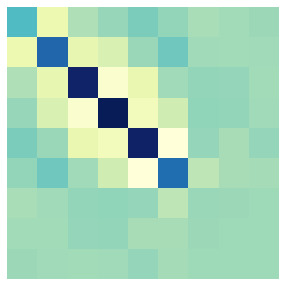

In [41]:
ax = sns.heatmap(opt_psi[:,:,5], cmap="YlGnBu", cbar=None, fmt="d", xticklabels=False, yticklabels=False, square=True)

In [32]:
opt_psi[:,:,5]

array([[ 1.55763746e-01, -2.03786420e-01, -2.74820880e-02,
         1.54651643e-02,  6.06076324e-02,  2.26069678e-02,
        -1.92352215e-02, -7.72348038e-03,  3.78369969e-03],
       [-2.03786420e-01,  4.30477254e-01, -1.80940307e-01,
        -1.33067702e-01,  8.17794693e-03,  9.29142314e-02,
        -3.03745802e-03, -7.70804054e-03, -3.02950355e-03],
       [-2.74820880e-02, -1.80940307e-01,  6.73243638e-01,
        -2.96863846e-01, -1.94394911e-01, -4.31772362e-03,
         2.09055224e-02,  1.70715399e-02, -7.22182383e-03],
       [ 1.54651643e-02, -1.33067702e-01, -2.96863846e-01,
         7.11069618e-01, -2.38196235e-01, -1.02074526e-01,
         2.51298977e-02,  2.16064205e-02, -3.06879113e-03],
       [ 6.06076324e-02,  8.17794693e-03, -1.94394911e-01,
        -2.38196235e-01,  6.78727229e-01, -3.36328511e-01,
         1.60596041e-02, -1.32218565e-02,  1.85691002e-02],
       [ 2.26069678e-02,  9.29142314e-02, -4.31772362e-03,
        -1.02074526e-01, -3.36328511e-01,  4.079751

In [31]:
# Compute wavelet coefficients and features
W_est = opt_eval.compute_wavelet_coeffs(x_est)
W_opt = opt_eval.compute_wavelet_coeffs(x_opt)
features = opt_eval.compute_features(W_opt, W_est)
print(f'We have the following features:\n {features}')

config.top_classifier_select_n = 2
config.top_classifier_min_threshold = 0.01
classifier = TopClassifier(config)
labels = classifier.classify(features)
print(f'In the top hierarchy with have the labels: {labels}')

We have the following features:
 [[0.13562197 0.31947678 0.47635583]
 [0.13201825 0.26425496 0.56736969]
 [0.12205527 0.14210044 2.33316587]
 [0.11781426 0.10026628 1.06927867]
 [0.10195026 0.13775274 0.27046593]
 [0.0794802  0.16905171 1.9647127 ]
 [0.10209274 0.47990935 0.43583107]
 [0.17782077 0.28990905 0.15872099]
 [0.1986387  0.44925203 0.06302536]]
In the top hierarchy with have the labels: [None, None, [3], None, None, [3], None, None, None]


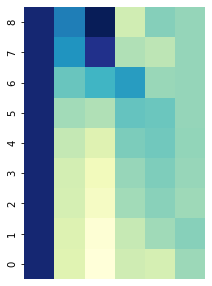

In [43]:
ax = sns.heatmap(W_opt, cmap="YlGnBu", cbar=None, fmt="d", xticklabels=False, yticklabels=True, square=True)
ax.invert_yaxis()
# plt.plot(W_opt[:,0], '-*')
# plt.plot(W_opt[:,1], '-*')
# plt.plot(W_opt[:,2], '-*')
# plt.plot(W_opt[:,3], '-*')
# W_opt.shape

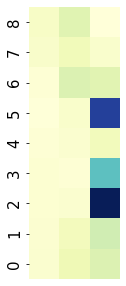

In [68]:
ax = sns.heatmap(features, cmap="YlGnBu", cbar=None, fmt="d", xticklabels=False, yticklabels=True, square=True)
ax.invert_yaxis()

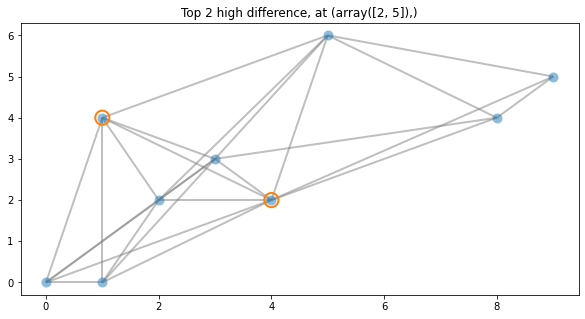

In [34]:
classified_labels = [l != None for l in labels]
peaks = np.where(classified_labels)
_ = est_graph.G.plot(title=f'Top {config.top_classifier_select_n} high difference, at {np.where(classified_labels)}', highlight=peaks)

## Let's Build Hierarchies!

[1661340473242453.2] HierarchicalGraph: Initialized with a threshold of 6.
got the indices [0 2 4 6 8]
[1661340473395465.2] HierarchicalGraph: Initialized with a threshold of 6.
got the indices [0 2 4 6 8]


(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Graph(n_vertices=5, n_edges=9)'}>)

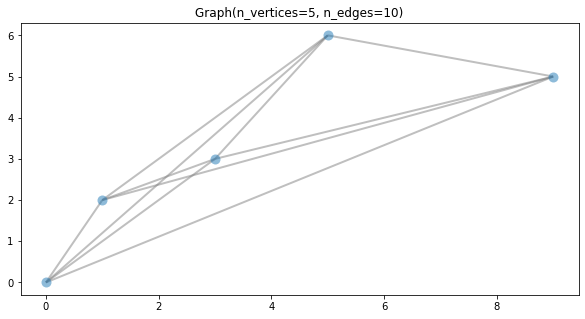

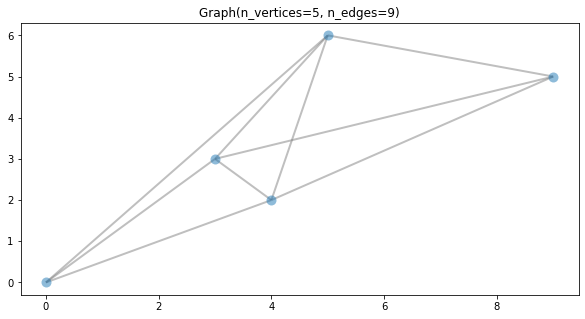

In [38]:
config.graph_hierarchies_node_threshold = 6

opt_graph = HierarchicalGraph(config)
opt_graph.build_from_poses(opt_traj[:,2:])
opt_graph.get_graph().plot()

est_graph = HierarchicalGraph(config)
est_graph.build_from_poses(est_traj[:,2:])
est_graph.get_graph().plot()


current indices are [0 2 4 6 8]
Marginalizing signal from 0 to 2
Marginalizing signal from 2 to 4
Marginalizing signal from 4 to 6
Marginalizing signal from 6 to 8
Marginalizing signal last from 8 to 9
Marginalizing signal from 0 to 2
Marginalizing signal from 2 to 4
Marginalizing signal from 4 to 6
Marginalizing signal from 6 to 8
Marginalizing signal last from 8 to 9


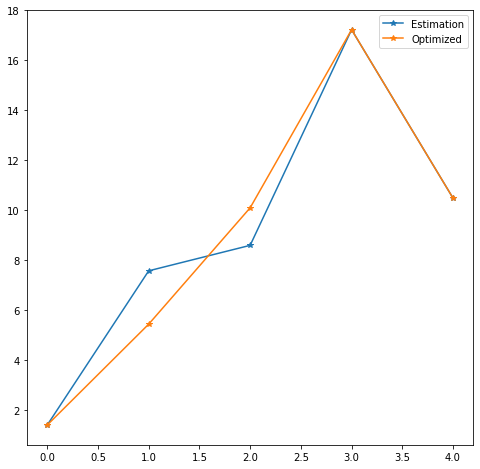

In [39]:
indices = opt_graph.get_indices()
print(f'current indices are {indices}')

x_est = opt_signal.marginalize_signal(x_est, indices, opt_graph.G[0].N)
x_opt = est_signal.marginalize_signal(x_opt, indices, opt_graph.G[0].N)


fig, axes = plt.subplots(1, 1, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5)

axes.plot(x_est, '-*', label='Estimation')
axes.plot(x_opt, '-*', label='Optimized')
axes.legend()

In [43]:
opt_eval = WaveletEvaluator(n_scales)
opt_psi = opt_eval.compute_wavelets(opt_graph.get_graph())

# Compute wavelet coefficients and features
W_est = opt_eval.compute_wavelet_coeffs(x_est)
W_opt = opt_eval.compute_wavelet_coeffs(x_opt)
features = opt_eval.compute_features(W_opt, W_est)
print(f'We have the following features:\n {features}')

top_n = 2
classifier = TopClassifier(top_n)
labels = classifier.classify(features)
print(f'In the top hierarchy with have the labels: {labels}')

[1661340879611939.8] WaveletEvaluator: Created with ranges: [array([0, 1, 2, 3]), array([4, 5, 6, 7]), array([ 8,  9, 10, 11])].
[1661340879612045.5] WaveletEvaluator: Computing wavelets for 12 scales.
We have the following features:
 [[0.1262328  0.         0.85637365]
 [0.1262328  0.         2.05200504]
 [0.1262328  0.         1.83483283]
 [0.1262328  0.         0.59420608]
 [0.1262328  0.         0.56702093]]
In the top hierarchy with have the labels: [None, [3], [3], None, None]


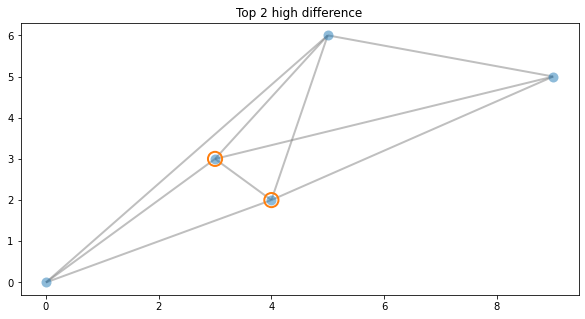

In [44]:
classified_labels = [l != None for l in labels]
peaks = np.where(classified_labels)
_ = est_graph.get_graph().plot(title=f'Top {top_n} high difference', highlight=peaks)

Downstream labels: [[], [], [3], [3], [3], [3], [], [], []]


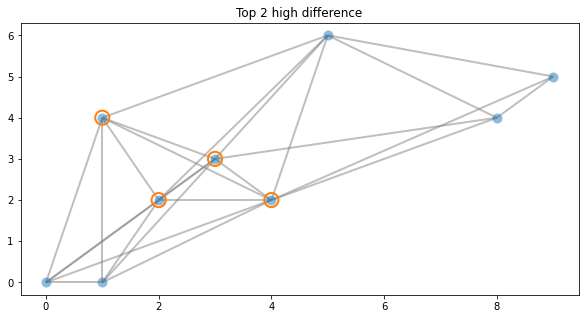

In [45]:

result = DownstreamResult(config, robot, all_opt_nodes, features, labels, opt_graph.get_indices())
print(f'Downstream labels: {result.labels}')

classified_labels = [len(l) > 0 for l in result.labels]
peaks = np.where(classified_labels)
_ = est_graph.G[0].plot(title=f'Top {top_n} high difference', highlight=peaks)